# Make with database: National Stock Exchange : Time Series
- Link: https://www.kaggle.com/datasets/atulanandjha/national-stock-exchange-time-series

# Connect gg drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path_dataset = "/content/drive/MyDrive/Class/nam-4/ky-1/ML/TH2/Dataset/RNN_LSTM"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing libraries

In [3]:
import numpy as np
import pandas as pd
import gc
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from IPython.display import clear_output
import time

In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential, Input, initializers, optimizers, callbacks, layers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.model_selection import train_test_split
from keras.layers import SimpleRNN
from keras.layers import GRU
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, BatchNormalization, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D

# Loading data

In [5]:
df = pd.read_csv(path_dataset + "/infy_stock.csv",
                 usecols=['Date', 'Close'], parse_dates=['Date'],index_col='Date')
df.shape

(248, 1)

In [6]:
print("Min:",df.index.min())
print("Max:",df.index.max())

Min: 2015-01-01 00:00:00
Max: 2015-12-31 00:00:00


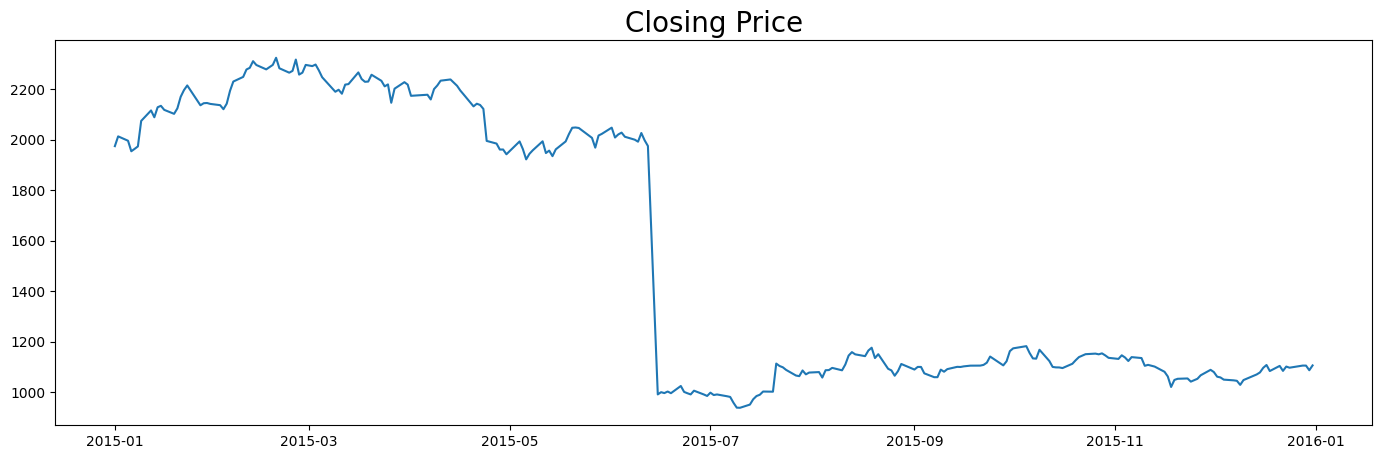

In [7]:
plt.figure(figsize=(17,5))
plt.plot(df['Close'])
plt.title("Closing Price",fontsize=20)
plt.show()

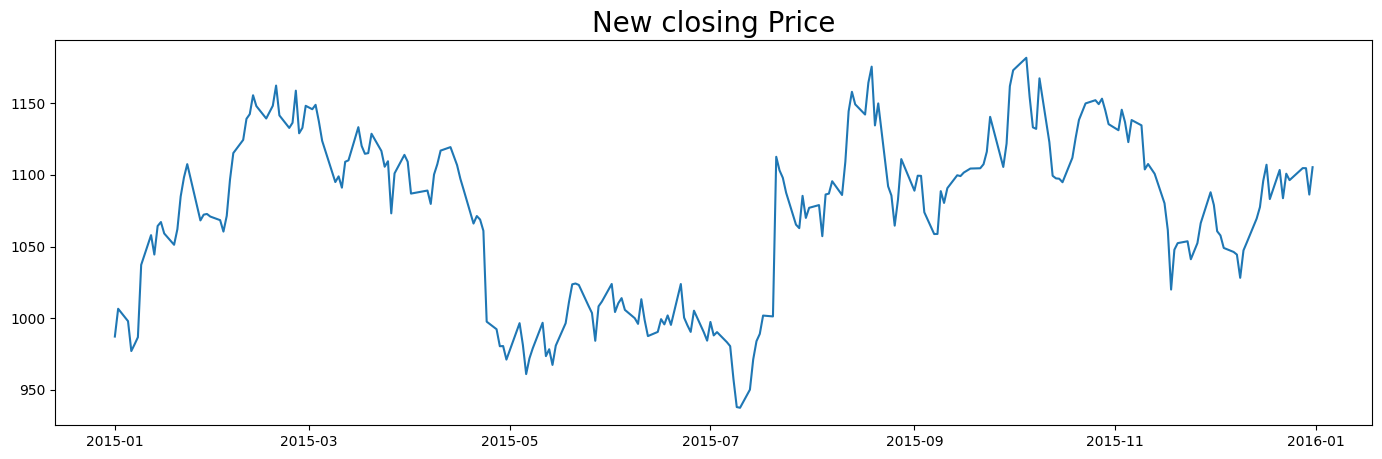

In [8]:
prices = pd.concat([df.Close[:'2015-06-12']/2,df.Close['2015-06-15':]])
plt.figure(figsize=(17,5))
plt.plot(prices)
plt.title("New closing Price",fontsize=20)
plt.show()

# Scalling

In [9]:
scaler = StandardScaler()
prices = scaler.fit_transform(prices.values.reshape(-1, 1)).flatten()
train, test = train_test_split(prices, test_size=0.3, shuffle=False)

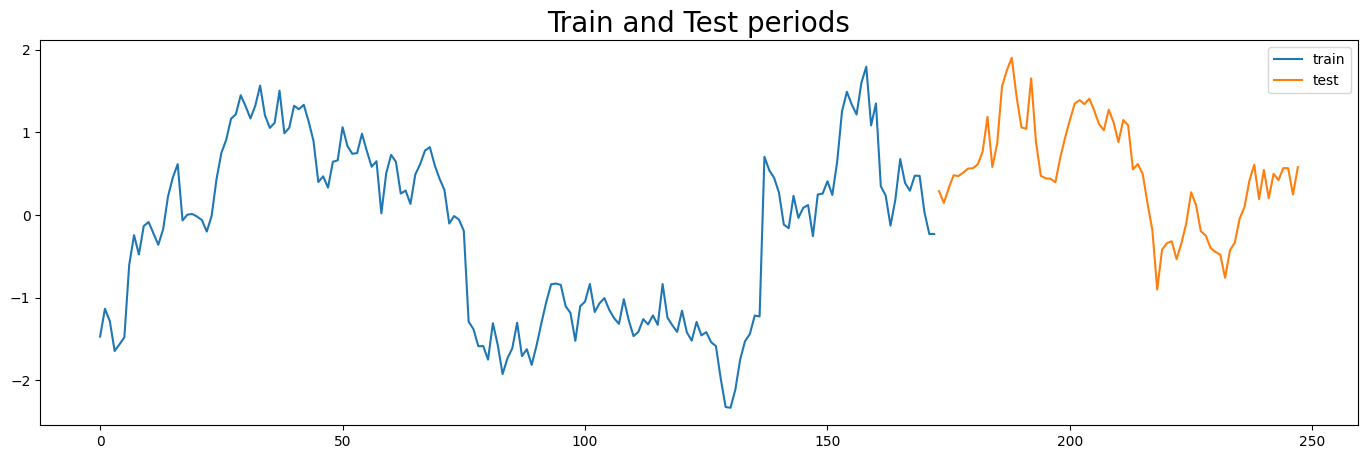

In [10]:
plt.figure(figsize=(17,5))
plt.plot(train, label='train')
plt.plot(np.arange(len(train), len(train)+len(test)), test, label='test')
plt.title("Train and Test periods", fontsize=20)
plt.legend()

In [11]:
def get_chunks(train, n_input, n_out=7):
    X, y = list(), list()
    in_start = 0
    for _ in range(len(train)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(train):
            x_input = train[in_start:in_end]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(train[in_end:out_end])
            in_start += 1
    return np.array(X),np.array(y)

In [12]:
n_input = 7
X_train, y_train = get_chunks(train, n_input=n_input, n_out=1)
X_test, y_test = get_chunks(test, n_input=n_input, n_out=1)

In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [14]:
fit_params = {
        'x': X_train,
        'y': y_train,
        'validation_data': (X_test, y_test),
        'verbose': 1,
        'epochs': 40,
        'batch_size': 16}

In [15]:
def results_plot(history):

    plt.figure(figsize=(17,5))
    plt.plot(history.history['loss'], color='b', label="train loss")
    plt.plot(history.history['val_loss'], color='r', label="val loss")

    plt.plot()

def plot_preds(y_test, preds):

    plt.figure(figsize=(17,5))
    plt.plot(preds, label='preds')
    plt.plot(y_test, label='test')
    plt.legend()
    plt.title('Real test and predicted')
    plt.show()

In [16]:
def mae(y_true, y_pred):
    output_errors = np.average(np.abs(y_pred - y_true), axis=0)
    return np.average(output_errors)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

def brief_stats(y_true, y_pred):
    print(pd.Series({
        'mape': mape(y_true, y_pred),
        'mae': mae(y_true, y_pred),
        'rmse': rmse(y_true, y_pred),
    }))

In [17]:
def base_rnn():
    model = Sequential()
    model.add(SimpleRNN(1, input_shape=(1,n_input),
                   return_sequences=False
                  ))
    model.compile(loss='mse', optimizer='adam')
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.3512 - val_loss: 0.2630
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3127 - val_loss: 0.2595
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2641 - val_loss: 0.2560
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3207 - val_loss: 0.2522
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2933 - val_loss: 0.2486
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3193 - val_loss: 0.2453
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3277 - val_loss: 0.2414
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3194 - val_loss: 0.2377
Epoch 9/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2726 - val_loss: 0.2341
Epoch 10/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2453 - val_loss: 0.2303
Epoch 11/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2894 - val_loss: 0.2268
Epoch 12/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3113 - val_l

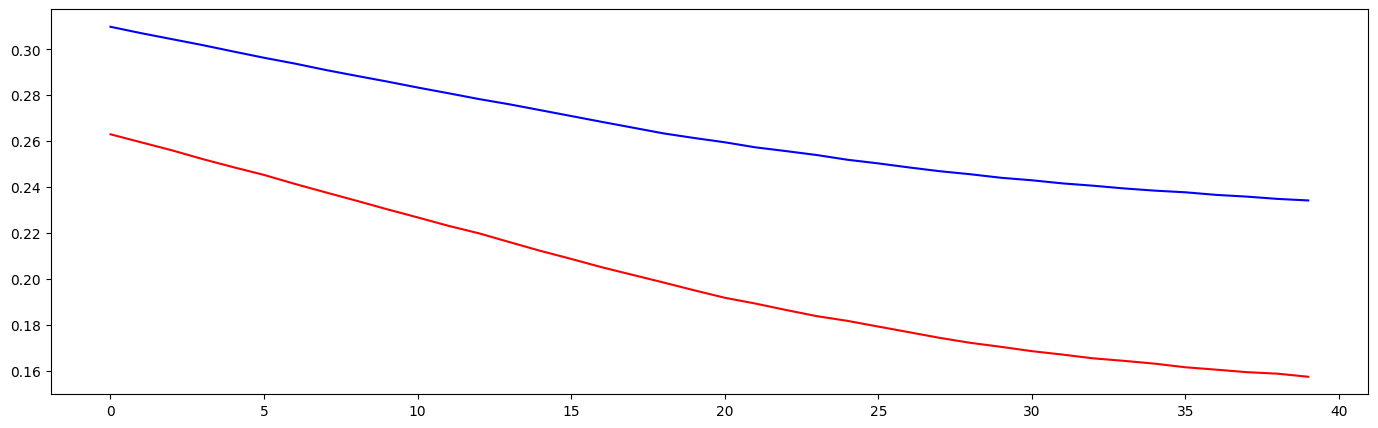

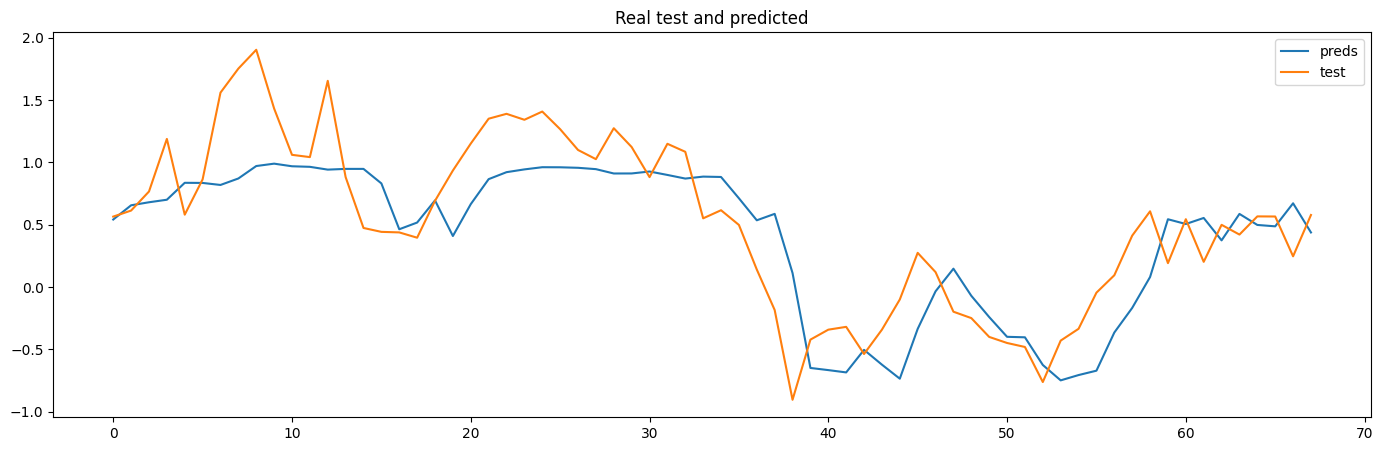

mape    96.134927
mae      0.316286
rmse     0.396689
dtype: float64


In [18]:
rnn_model = base_rnn()
history_rnn =  rnn_model.fit(**fit_params)
results_plot(history_rnn)

preds = rnn_model.predict(X_test).flatten()
plot_preds(y_test[:, 0], preds)
brief_stats(y_test[:, 0], preds)

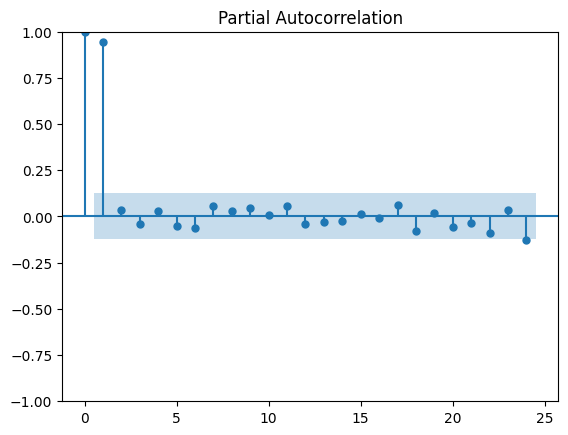

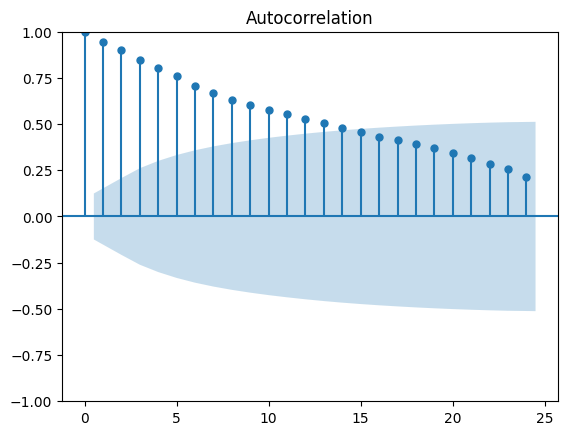

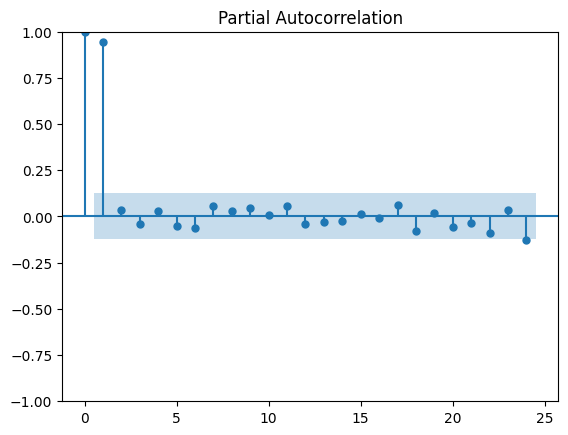

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_acf(prices)
plot_pacf(prices)